# <b> The Worst Criminal Charges</b>
#### <i> & how they correlate with demographic data</i>

todo: <b><u><span style="color:red">add alt text</span></u> & convert multi-line bar charts to overlapped bars (NOT stacked)</b>

In [1]:
import numpy as np
import pandas as pd
import glob, os, warnings, datetime

#suppressing mixed dtypes, null vals in years without data
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    arrests_original = pd.read_csv("Desktop/CMPU/arrests_2011_2025.csv")
arrests_original = arrests_original.drop("Unnamed: 0", axis=1)

In [2]:
#split data by categories. this is gross and could definitely be better somehow. Anyways, the naiive way is good enough for me
#input: arrests dataset without null values as charges. Output Series containing overlapping subsets of arrests grouped by drug, sex, attack/violence, driving/traffic, legal/processural, immigration, and other -related charges
def categorize_charges(arr):
    worst_charge = arr["Worst Criminal Charge"].str.lower()
    
    #keywords to associate with categories
    drug_keywords = ['drug', 'marijuana', 'narcotic', 'liquor', 'cocaine', 'heroin', 'opium', 'amphetamine', 'hallucinogen', 'obscene material']
    sex_keywords = ['sex', 'indecent exposure', 'molest', 'rape', 'prostitute', 'prostitution', 'incest', 'seduction', 'bestiality', 'adultery', 'lewd', 'lascivious', 'voyeur', 'peeping tom']
    attack_keywords = ['viisolence', 'assault', 'battery', 'homicide', 'kill', 'murder', 'manslaughter', 'threat to', 'weapon', 'arson', 'threaten', 'gun', 'kidnap', 'terroris']
    traffic_keywords = ['traffic', 'driv', 'road', 'vehic', 'car', 'hit and run']
    legal_keywords = ['officer', 'police', 'interfere', 'obstruct', 'failing to appear', 'licensing', 'probation', 'justice', 'failure to appear']
    immigration_keywords = ['immigra', 'alien', 'illegal entry', 'illegal re-entry', 'illegal arrest', 'pass forged', 'false citizenship']
    monitary_keywords = ['gambl', 'larceny', 'shoplifting', 'theft', 'steal', 'burglary', 'launder', 'robbery', 'embezzle']
    
    #just to make this a tad more readible
    def keyword_charges(keyword):
        return arr[worst_charge.str.contains('|'.join(keyword))]
    
    #take into categories, contains overlaps
    drug = keyword_charges(drug_keywords) #drug-related charges
    sex = keyword_charges(sex_keywords) #sex-related charges
    attack = keyword_charges(attack_keywords) #attack/violent defined by indication of bodily harm to an individual. these are weapons, assault, battery, threat, etc  
    traffic = keyword_charges(traffic_keywords) #may accidentally pick up human & drug trafficking in low quantities
    legal = keyword_charges(legal_keywords) #things related to intereference with police, obstructing justice, failing to work within the court system, breaking probation, etc
    immigration = keyword_charges(immigration_keywords) #immigration status related charges
    monitary = keyword_charges(monitary_keywords) #gambling & stealing
    
    #get everyone with listed charge not included in other categories
    other = arr[~worst_charge.str.contains('|'.join(drug_keywords+sex_keywords+attack_keywords+traffic_keywords+legal_keywords+immigration_keywords+monitary_keywords))]
    return pd.Series([drug, sex, attack, traffic, legal, immigration, monitary, other], \
                    ['Drug', 'Sex', 'Violent', 'Traffic', 'Legal', 'Immigration', 'Monitary', 'Other'])

In [3]:
#we're only looking at instances where they have recorded criminal charges (not necessarily convicted). 
#This reduces our data to ~700k entries, 40% of the total dataset
arrests_charges = arrests_original.dropna(subset="Worst Criminal Charge")

### Let's give this data a cursory glance:

<Axes: title={'center': 'Naiive Look at Charges'}, xlabel='Worst Criminal Charge'>

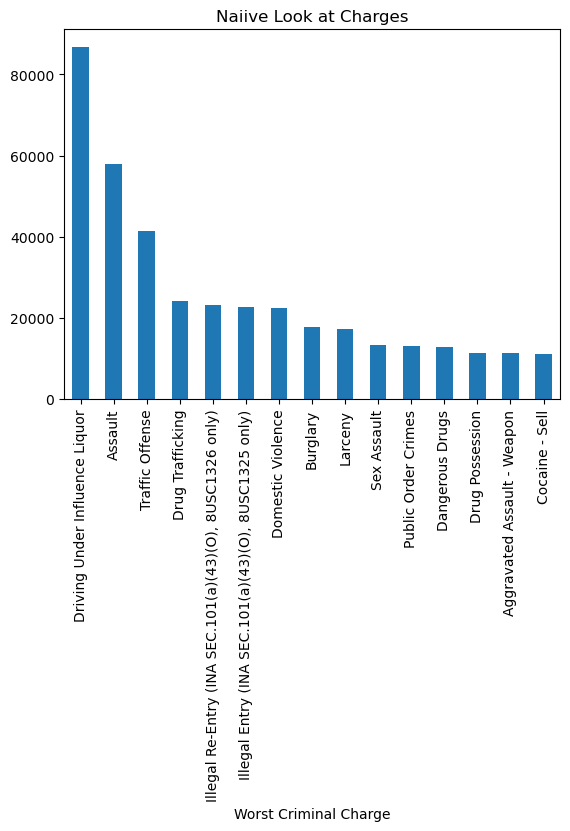

In [4]:
arrests_charges["Worst Criminal Charge"].value_counts()[:15].plot.bar(title = "Naiive Look at Charges")

#### <b>At a glance, this looks like a strong indicator for traffic offenses (including drunk driving) to be <i>by far</i> the worst charge levied against individuals arrested by ICE.</b>

Unfortunately, this naiive approach has a major issue:
We aren't agglutinating most offenses yet, so anything with a more diverse naming schema is getting spread out across the graph
The best example of this is drug offenses, for which most types of drugs have their own categories, and selling, transporting, using, and posessing all have different classifications. To remedy this, let's group these by the categories created in 'categorize_chrages(arrests)' and re-graph it.


<Axes: >

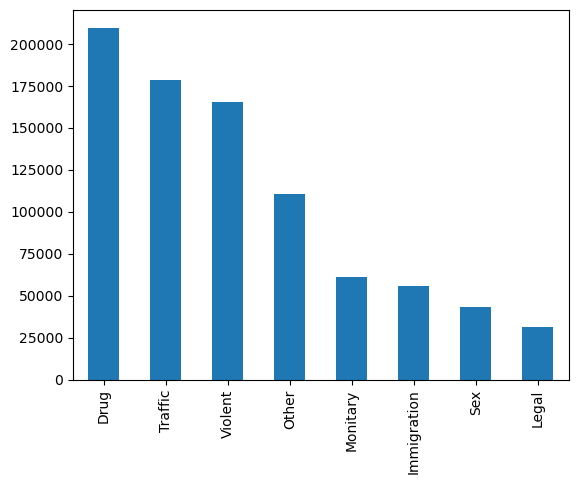

In [5]:
# compare charge types, input a DF subset of the arrests charges dataset
def offense_visu(charges):
    #takes a df, subset of arrests, gives how many criminal charges are in it.
    def count(charge_subset):
        return charge_subset["Worst Criminal Charge"].size

    #bar graph how many times a category appears within the total arrests dataset
    return categorize_charges(charges).apply(count).sort_values(ascending=False)

all_charges_cat = offense_visu(arrests_charges)
all_charges_cat.plot.bar()

### Now, the story looks different: Drug crime & personally-violent crime seem to be <i>more</i> common charges than traffic offenses!

<i>This is a rough categorization. These are overlapping subsets, and are not perfect. Many contain extra charges that do not actually reflect the category, and just as often are relevant charges left out. That being said, the bulk of these categories is approximately correct, and artifacts are not avoidable without significant human intervention (as across years and individual variances, there are no consistent labels for criminal charges).</i>

<br>

#### This lets us see a bit better what types of things we want to look at, but it still has problems, now with over-generalization
<b>So let's build some more specific visualization tools!</b>



In [6]:
#visualize drug charges
#Input: subset of arrest DF containing only drug-related charges. Output: sorted series of agglutinated value counts
def drug_visu(drug):
    drug_vc = drug["Worst Criminal Charge"].value_counts()
    
    #agg vars
    idx = ['Distribution/Selling', 'Posession', 'Manufacture', 'Transport/Smuggling', 'Driving Under Influence', 'Unspecified/Other']
    drug_agg = pd.Series((0,)*6, idx)
    
    #loops for each item in val_counts and if it's selling, manufacture, posession, smuggling, or  we agglutinate it
    for k,v in drug_vc.items():
        k=k.lower()
        
        #switch based on substring matches
        i = idx[0] if ('sell' in k) | ('distribut' in k) else \
            idx[1] if 'possession' in k else \
            idx[2] if 'manufactur' in k else \
            idx[3] if ('smuggl' in k) | ('transport' in k) | ('traffic' in k) else \
            idx[4] if 'driv' in k else \
            idx[5]
        
        #agglutinate
        drug_agg[i] += v
        
    return drug_agg.sort_values(ascending=False)

In [7]:
#visualize traffic charges, slightly modified drug_visu. TODO: consolidate into one function?
#Input: subset of arrest DF containing only traffic-related charges. Output: sorted series of agglutinated value counts
def traffic_visu(traffic):
    traffic_vc = traffic["Worst Criminal Charge"].value_counts()

    traffic_vc.drop(["Carrying Prohibited Weapon", "Fraud - Illegal Use Credit Cards", "Weapon Trafficking", "Carrying Concealed Weapon", "Sex Assault - Carnal Abuse", "Human Slavery or Trafficking", "Drug Trafficking"])

    #agg vars
    idx = ['Theft', 'Intoxicated Driving', 'Traffic Stop', 'Other']
    traffic_agg = pd.Series((0,)*4, idx)
    
    #loops for each item in val_counts and if it's selling, manufacture, posession, smuggling, or  we agglutinate it
    for k,v in traffic_vc.items():
        k=k.lower()
        
        #switch based on substring matches
        i = idx[0] if ('theft' in k) | ('stolen' in k) | ('carjack' in k) | ('larceny' in k) | ('strip' in k) else \
            idx[1] if 'influence' in k else \
            idx[2] if 'traffic' in k else \
            idx[3]
        
        #agglutinate
        traffic_agg[i] += v
        
    return traffic_agg.sort_values(ascending=False)

In [8]:
#Make some datasets that we can now use our visualization suite on by
def deported(arr):
    return arr.dropna(subset= "Departure Country")

def hispanic(arr):
    return arr[arr.Ethnicity=="Hispanic Origin"]
    
#Splitting into different overlapping subsets. this is quite slow unfortunately. Store as series for easy parsing
charges_all = categorize_charges(arrests_charges) #everyone
charges_deported = categorize_charges(deported(arrests_charges)) #deported
charges_hispanic = categorize_charges(hispanic(arrests_charges)) #hispanic
charges_hispanic_deported = categorize_charges(hispanic(deported(arrests_charges))) #deported and hispanic

<Axes: title={'center': 'Demographics of Traffic Charges'}>

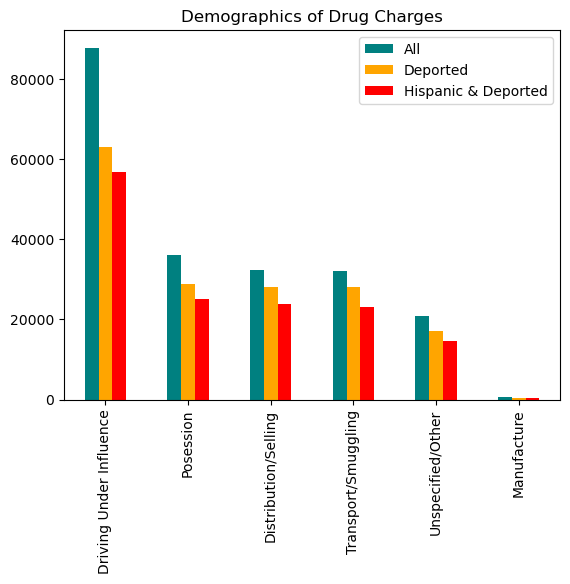

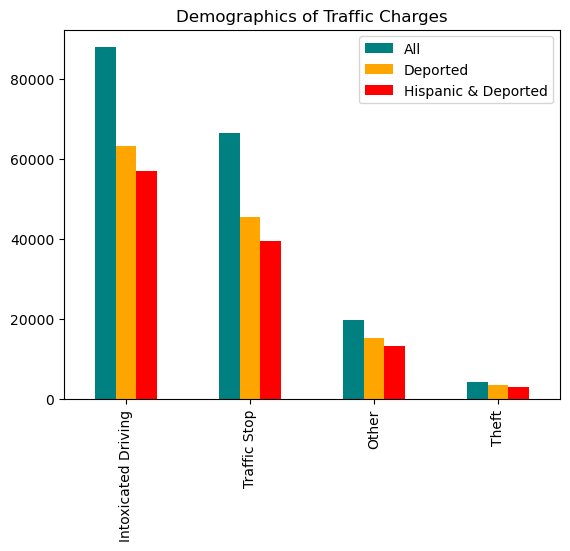

In [9]:
#display various figures
drug_factors = pd.DataFrame()
drug_factors["All"] = drug_visu(charges_all.Drug)
drug_factors["Deported"] = drug_visu(charges_deported.Drug)
drug_factors["Hispanic & Deported"] = drug_visu(charges_hispanic_deported.Drug)

traffic_factors = pd.DataFrame()
traffic_factors["All"] = traffic_visu(charges_all.Traffic)
traffic_factors["Deported"] = traffic_visu(charges_deported.Traffic)
traffic_factors["Hispanic & Deported"] = traffic_visu(charges_hispanic_deported.Traffic)

drug_factors.plot.bar(color = ["teal", "orange", "red"], title = "Demographics of Drug Charges")
traffic_factors.plot.bar(color = ["teal", "orange", "red"], title = "Demographics of Traffic Charges")


### Looking just within drug-related charges, we can see how often individuals who are charged are deported, and how often the deportees are hispanic. 

Let's look at those same demographics across all charges:

In [10]:
#make a quick dataframe to plot
total_factors = pd.DataFrame()

total_factors["All"] = all_charges_cat #just a reminder that it exists :p
total_factors["Hispanic"] = offense_visu(hispanic(arrests_charges)) #hispanic
total_factors["Deported"] = offense_visu(deported(arrests_charges)) #deported
total_factors["Hispanic & Deported"] = offense_visu(hispanic(deported(arrests_charges))) #deported & hispanic

<Axes: title={'center': 'Demographics of Charged & ICE-Arrested Individuals'}>

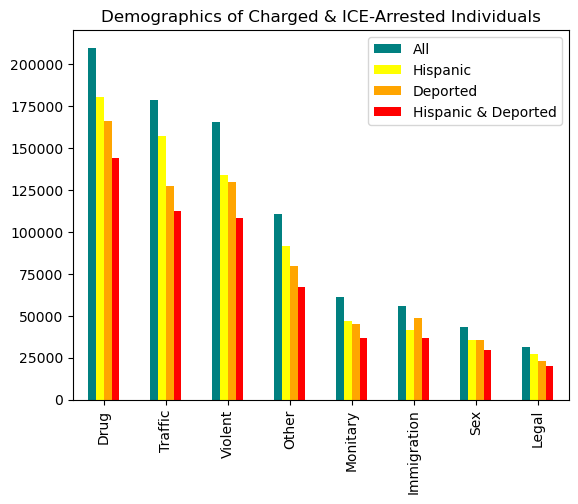

In [11]:
total_factors.plot.bar(color = ["teal", "yellow", "orange", "red"], title = "Demographics of Charged & ICE-Arrested Individuals")

## <b>This seems a good indication that we should look into the correlation between ethnicity and ICE arrests & deportations more generally</b>

<i>Which makes this a good time for logistic regression, with a binary classifier of "deported". We will expect hispanic origin to be a strong predictor of if an individual is deported, simply due to the geography of the USA and Mexico. We should also expect that criminal status will also be a strong predictor, due to how often arrests are made of individuals already involved with the criminal justice system.</i>

In [12]:
import sklearn as sk
from sklearn.model_selection import train_test_split

arrests = arrests_original
arrests["Hispanic"] = arrests.Ethnicity == "Hispanic Origin"
arrests["Charged"] = ~arrests["Worst Criminal Charge"].isna()

X = arrests[arrests.columns[-2:]]
y = ~arrests["Departure Country"].isna()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

algo = sk.linear_model.LogisticRegression()
model = algo.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("MSE: ", sk.metrics.mean_squared_error(y_pred, y_test))
print("Arrests in Prison: ", round(arrests["Apprehension Site Landmark"].str.lower().str.contains("jail|prison").sum()\
            /arrests["Apprehension Site Landmark"].size*100, 3), "%")

MSE:  0.22816139583032263
Arrests in Prison:  24.016 %


<br>This MSE of <b>0.229</b> shows that the two factors of Criminality & Hispanic identity together are a strong predictor of whether an individual was deported. This is entierly within expectations, given <b><u>24.016%</b></u> of arrests across the entire dataset were made in prisons or jails (alongside the knowledge of the aformentioned geography of the USA)
<br><br>
This tells us that a very significant avenue to ICE encounters and deportation is criminalization and incarceration. This could demonstrate that one substantial avenue to inhibiting deportations and protecting at-risk groups is reducing entry into the CJS in the first place. This is not easily or immediately actionable, though diversion programs & community mutual-aid may be places to start (in fact, they are already places in which significant work has already been occuring). 
<br><br>
Finally, while driving-related charges are the second most common category in this dataset, the most common drug-related offense (over double the runner-up) is a citation for driving while intoxicated. The second most common traffic charge is (after driving intoxicated) a general traffic stop/citation. Perhaps a legislative angle then should consider one of the very common ways that municiple police profile & target individuals: traffic stops! They do not require warrents, and due to how road laws are currently implemented, provide individual officers with a high degree of discretion that significantly contributes to the broader PIC. <b>If we wish to protect at-risk individuals from ICE, we need to also protect them from the broader CJS.</b>